<a href="https://colab.research.google.com/github/lilarogers4/ANN-Money-Money-Money/blob/main/ANN_Money%2C_Money%2C_Money.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MONEY, MONEY, MONEY**
In this project, we develop an ANN-based predictive model for exchange rates using historical macroeconomic data from multiple years. Our focus is to evaluate how macroeconomic indicators such as Gross Domestic Product (GDP), inflation, unemployment, interest rates, and trade balance contribute to exchange rate changes.

**The goal is to determine whether a currency's exchange rate will appreciate or depreciate in the following month.**

We use JPY and USD in this iteration.


---



### Data Loading and Initial Preparation
This section imports necessary libraries like `pandas` and `matplotlib`. It then loads the `YenUSD.csv` dataset, renames the `observation_date` column to `Date`, sets `Date` as the index, and converts the `DEXJPUS` column to a numeric type, renaming it to `exchangeRate`. It also loads `US_Debt.csv`.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("YenUSD.csv")
df_debt = pd.read_csv('US_Debt.csv')
df = df.rename(columns={'observation_date': 'Date'})
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
print(df.tail())

            DEXJPUS
Date               
2025-11-10   153.99
2025-11-11      NaN
2025-11-12   154.64
2025-11-13   154.40
2025-11-14   154.64


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
df['DEXJPUS'] = pd.to_numeric(df['DEXJPUS'])
df = df.rename(columns={'DEXJPUS': 'exchangeRate'})


In [ ]:
# Z-score of exchange-rate vs SMA
df['SMA_14'] = df['exchangeRate'].rolling(window=14).mean()
df['STD_14'] = df['exchangeRate'].rolling(window=14).std()

df['Z_Score'] = (df['exchangeRate'] - df['SMA_14']) / df['STD_14']
print(df.head(30))

            exchangeRate      SMA_14    STD_14   Z_Score
Date                                                    
1971-01-04        357.73         NaN       NaN       NaN
1971-01-05        357.81         NaN       NaN       NaN
1971-01-06        357.86         NaN       NaN       NaN
1971-01-07        357.87         NaN       NaN       NaN
1971-01-08        357.82         NaN       NaN       NaN
1971-01-11        357.95         NaN       NaN       NaN
1971-01-12        358.06         NaN       NaN       NaN
1971-01-13        358.44         NaN       NaN       NaN
1971-01-14        358.40         NaN       NaN       NaN
1971-01-15        358.40         NaN       NaN       NaN
1971-01-18        358.29         NaN       NaN       NaN
1971-01-19        358.35         NaN       NaN       NaN
1971-01-20        358.40         NaN       NaN       NaN
1971-01-21        358.27  358.117857  0.269278  0.565004
1971-01-22        357.90  358.130000  0.253832 -0.906111
1971-01-25        357.73  358.1

### Feature Engineering - Technical Indicators
This section calculates various technical indicators. It computes the Z-score of the exchange rate against its Simple Moving Average (SMA), defines a function to calculate Wilder's Relative Strength Index (RSI), and creates features for directional run lengths.

In [ ]:
def get_Wilder_RSI(df):

  #Split into two week periods and calculate the delta
  df_2w = df.resample('M').mean()
  df_2w.dropna()
  df_2w['Delta'] = df_2w['exchangeRate'].diff()

  df_2w['Gain'] = df_2w['Delta'].clip(lower=0)
  df_2w['Loss'] = -df_2w['Delta'].clip(upper=0)
  window = 14
  #using Wilder's formula for RSI
  avg_gain = df_2w['Gain'].ewm(alpha=1/window, min_periods=window).mean()
  avg_loss = df_2w['Loss'].ewm(alpha=1/window, min_periods=window).mean()
  rs = avg_gain / avg_loss
  df_2w['RSI'] = 100 - (100 / (1 + rs))

  print(df_2w.tail(20))

  return df_2w




In [ ]:
df['Direction'] = df['exchangeRate'].diff().apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

def run_length(df, col='Direction'):
    run_lengths = []
    current_run = 0
    current_dir = 0

    for dir_i in df[col]:
        if dir_i == 0:
            current_run = 0
            current_dir = 0
        elif dir_i == current_dir:
            current_run += 1
        else:
            current_run = 1
            current_dir = dir_i
        run_lengths.append(current_run)

    df['RunLength'] = run_lengths
    return df
df = run_length(df)

print(df[70:80])


            exchangeRate      SMA_14    STD_14   Z_Score  Direction  RunLength
Date                                                                          
1971-04-12        357.50  357.492857  0.038914  0.183556          0          0
1971-04-13        357.62  357.499286  0.051060  2.364157          1          1
1971-04-14        357.58  357.507143  0.054551  1.335576         -1          1
1971-04-15        357.50  357.509286  0.053560 -0.173370         -1          2
1971-04-16        357.54  357.516429  0.050170  0.469831          1          1
1971-04-19        357.49  357.516429  0.050170 -0.526780         -1          1
1971-04-20        357.49  357.521429  0.042762 -0.734968          0          0
1971-04-21        357.49  357.521429  0.042762 -0.734968          0          0
1971-04-22        357.49  357.518571  0.043475 -0.657186          0          0
1971-04-23        357.49  357.517857  0.043884 -0.634787          0          0


In [ ]:
df_jpn_gdp = pd.read_csv('Japan_GDP.csv')
df_us_gdp = pd.read_csv('US_GDP.csv')
df_us_unemployment = pd.read_csv('US_Unemployment.csv')
df_jpn_unemployment = pd.read_csv('Japan_Unemployment.csv')
df_jpn_m2 = pd.read_csv('M2_Japan.csv')
df_us_m2 = pd.read_csv('M2_US.csv')
df_us_10yield = pd.read_csv('US_10yield.csv')
df_jpn_10yield = pd.read_csv('JPN_10yield.csv').reset_index(drop=True)
dfs = {
    "df_jpn_gdp": df_jpn_gdp,
    "df_us_gdp": df_us_gdp,
    "df_us_unemployment": df_us_unemployment,
    "df_jpn_unemployment": df_jpn_unemployment,
    "df_jpn_m2": df_jpn_m2,
    "df_us_m2": df_us_m2,
    'df_us_10yield': df_us_10yield
}

def process(df):
    df = df.set_index('observation_date')
    df.index = pd.to_datetime(df.index)
    df = df.resample('D').ffill()
    df = df.reset_index()
    return df

for name in dfs:
    dfs[name] = process(dfs[name])

df_jpn_gdp = dfs["df_jpn_gdp"]
df_us_gdp = dfs["df_us_gdp"]
df_us_unemployment = dfs["df_us_unemployment"]
df_jpn_unemployment = dfs["df_jpn_unemployment"]
df_jpn_m2 = dfs["df_jpn_m2"]
df_us_m2 = dfs["df_us_m2"]


df_jpn_10yield = df_jpn_10yield.reset_index(drop=True)
df_jpn_10yield = df_jpn_10yield.reset_index(drop=True)

print(df_jpn_10yield.head())

print(len(df_us_gdp))
print(len(df_jpn_gdp))
print(len(df_jpn_unemployment))
print(len(df_us_unemployment))
print(len(df_jpn_m2))
print(len(df_us_m2))

  Interest Rate Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4 Unnamed: 5  \
0          Date         1Y         2Y         3Y         4Y         5Y   
1     1974/9/24     10.327      9.362       8.83      8.515      8.348   
2     1974/9/25     10.333      9.364      8.831      8.516      8.348   
3     1974/9/26      10.34      9.366      8.832      8.516      8.348   
4     1974/9/27     10.347      9.367      8.833      8.517      8.349   

  Unnamed: 6 Unnamed: 7 Unnamed: 8 Unnamed: 9 Unnamed: 10 Unnamed: 11  \
0         6Y         7Y         8Y         9Y         10Y         15Y   
1       8.29       8.24      8.121      8.127           -           -   
2       8.29       8.24      8.121      8.127           -           -   
3       8.29       8.24      8.122      8.128           -           -   
4       8.29       8.24      8.122      8.128           -           -   

  Unnamed: 12 Unnamed: 13 Unnamed: 14 (Unit : %)  
0         20Y         25Y         30Y        40Y  
1           - 

In [ ]:
import pandas as pd



def prep_macro_df(df_raw, new_name):
    df = df_raw.copy()

    if 'DATE' in df.columns:
        date_col = 'DATE'
    elif 'observation_date' in df.columns:
        date_col = 'observation_date'
    else:
        raise ValueError(f"No DATE or observation_date column found in {df.columns}")

    df[date_col] = pd.to_datetime(df[date_col])


    value_cols = [c for c in df.columns if c != date_col]
    if len(value_cols) != 1:
        raise ValueError(f"Expected 1 value column, got {value_cols}")
    value_col = value_cols[0]

    df = df[[date_col, value_col]].rename(
        columns={date_col: 'DATE', value_col: new_name}
    )

    return df

us_gdp          = prep_macro_df(df_us_gdp,          'US_GDP')
jpn_gdp         = prep_macro_df(df_jpn_gdp,         'Japan_GDP')

us_unemp        = prep_macro_df(df_us_unemployment, 'US_Unemployment')
jpn_unemp       = prep_macro_df(df_jpn_unemployment,'Japan_Unemployment')


us_m2           = prep_macro_df(df_us_m2,           'US_M2')
jpn_m2          = prep_macro_df(df_jpn_m2,          'Japan_M2')


print(len(us_gdp))
print(len(jpn_gdp))
print(len(df_us_unemployment))
print(len(df_jpn_unemployment))
print(len(df_us_m2))
print(len(df_jpn_m2))

df_us_unemployment.head()



macro_df = us_gdp.merge(jpn_gdp,   on='DATE', how='left')
macro_df = macro_df.merge(us_unemp, on='DATE', how='left')
macro_df = macro_df.merge(jpn_unemp,on='DATE', how='left')
macro_df = macro_df.merge(us_m2,    on='DATE', how='left')
macro_df = macro_df.merge(jpn_m2,   on='DATE', how='left')

macro_df = macro_df.sort_values('DATE').reset_index(drop=True)

print("Macro panel:")
print(macro_df.head())
print(macro_df.tail())



28581
11505
28338
20333
16406
22678
Macro panel:
        DATE   US_GDP  Japan_GDP  US_Unemployment  Japan_Unemployment  US_M2  \
0 1947-01-01  243.164        NaN              NaN                 NaN    NaN   
1 1947-01-02  243.164        NaN              NaN                 NaN    NaN   
2 1947-01-03  243.164        NaN              NaN                 NaN    NaN   
3 1947-01-04  243.164        NaN              NaN                 NaN    NaN   
4 1947-01-05  243.164        NaN              NaN                 NaN    NaN   

   Japan_M2  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
            DATE     US_GDP  Japan_GDP  US_Unemployment  Japan_Unemployment  \
28576 2025-03-28  30042.113   625114.0              4.2                 2.7   
28577 2025-03-29  30042.113   625114.0              4.2                 2.7   
28578 2025-03-30  30042.113   625114.0              4.2                 2.7   
28579 2025-03-31  30042.113   625114.0              4.2               

In [ ]:

macro_df = macro_df.dropna()
print(len(macro_df))



8433


### Logistic Regression Model
This section sets up and trains a Logistic Regression model to predict the direction of the exchange rate. It prepares macroeconomic and exchange rate data, aligns them by common dates, creates a binary target variable (up/down), generates lagged macroeconomic features, and then splits the data for training and testing. A pipeline is used for scaling and logistic regression, and the model's performance is evaluated.

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

macro_df['DATE'] = pd.to_datetime(macro_df['DATE'])
macro_df = macro_df.sort_values('DATE').reset_index(drop=True)

features = ['US_GDP', 'Japan_GDP', 'US_Unemployment', 'Japan_Unemployment',
            'US_M2', 'Japan_M2']
macro_df = macro_df.dropna(subset=features, how='all')

df = pd.read_csv("YenUSD.csv")
df = df.rename(columns={'observation_date': 'Date'})
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)


common_dates = macro_df['DATE'].isin(df['Date'])
macro_df_aligned = macro_df[common_dates].reset_index(drop=True)

exchange_rate_aligned = df[df['Date'].isin(macro_df_aligned['DATE'])]['DEXJPUS'].reset_index(drop=True)

target = (exchange_rate_aligned.shift(-1) > exchange_rate_aligned).astype(int)

macro_df_aligned = macro_df_aligned.iloc[:-1].reset_index(drop=True)
target = target.iloc[:-1].reset_index(drop=True)


for lag in range(1, 4):
    for col in features:
        macro_df_aligned[f'{col}_lag{lag}'] = macro_df_aligned[col].shift(lag)

lagged_features = [f'{col}_lag{lag}' for lag in range(1, 4) for col in features]

macro_df_final = macro_df_aligned.dropna(subset=lagged_features).reset_index(drop=True)
target_final = target[macro_df_final.index].reset_index(drop=True)


X = macro_df_final[lagged_features]
y = target_final

train_ratio = 0.8
split_index = int(len(X) * train_ratio)

X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]

X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]


model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])

model.fit(X_train, y_train)


y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.4941860465116279
Confusion Matrix:
 [[333 284]
 [325 262]]


### LSTM Model for Directional Prediction
This cell implements a basic LSTM to predict the direction of the exchange rate. It prepares the macroeconomic and exchange rate data, creates a directional target, scales features, and transforms data into sequences suitable for LSTM input. The model is trained with early stopping, and its performance is evaluated.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Prep data
macro_df['DATE'] = pd.to_datetime(macro_df['DATE'])
macro_df = macro_df.sort_values('DATE').reset_index(drop=True)

features = ['US_GDP', 'Japan_GDP', 'US_Unemployment', 'Japan_Unemployment',
            'US_M2', 'Japan_M2']
macro_df = macro_df.dropna(subset=features, how='all')

df = pd.read_csv("YenUSD.csv")
df = df.rename(columns={'observation_date': 'Date'})
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Fix dates
common_dates = macro_df['DATE'].isin(df['Date'])
macro_df_aligned = macro_df[common_dates].reset_index(drop=True)
exchange_rate_aligned = df[df['Date'].isin(macro_df_aligned['DATE'])]['DEXJPUS'].reset_index(drop=True)

target = (exchange_rate_aligned.shift(-1) > exchange_rate_aligned).astype(int)
macro_df_aligned = macro_df_aligned.iloc[:-1].reset_index(drop=True)
target = target.iloc[:-1].reset_index(drop=True)

# Sequences for LSTM
lookback = 4
data = macro_df_aligned[features].values
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

X, y = [], []
for i in range(lookback, len(data_scaled)):
    X.append(data_scaled[i-lookback:i])
    y.append(target[i])
X = np.array(X)
y = np.array(y)

# Train/test split
train_ratio = 0.8
split_index = int(len(X) * train_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build model
model = Sequential([
    LSTM(64, input_shape=(lookback, len(features)), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Performance
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob.flatten() > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5300 - loss: 0.6926 - val_accuracy: 0.5670 - val_loss: 0.6863
Epoch 2/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5437 - loss: 0.6895 - val_accuracy: 0.5670 - val_loss: 0.6855
Epoch 3/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5281 - loss: 0.6913 - val_accuracy: 0.5670 - val_loss: 0.6985
Epoch 4/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5412 - loss: 0.6869 - val_accuracy: 0.5670 - val_loss: 0.7082
Epoch 5/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5291 - loss: 0.6891 - val_accuracy: 0.5670 - val_loss: 0.7053
Epoch 6/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5419 - loss: 0.6873 - val_accuracy: 0.5670 - val_loss: 0.6981
Epoch 7/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5297 - loss: 0.6911 - val_accuracy: 0.5670 - val_loss: 0.7071
Epoch 8/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5340 - loss: 0.6900 - val_accuracy: 0.5670

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Prep data
macro_df['DATE'] = pd.to_datetime(macro_df['DATE'])
df['Date'] = pd.to_datetime(df['Date'])

# Merge dataframes on dates
merged_df = pd.merge(macro_df, df, left_on='DATE', right_on='Date', how='inner')
merged_df = merged_df.sort_values('DATE').reset_index(drop=True)

features = ['US_GDP', 'Japan_GDP', 'US_Unemployment', 'Japan_Unemployment',
            'US_M2', 'Japan_M2']

# NaN values
merged_df = merged_df.dropna(subset=features + ['DEXJPUS'])

# Extract features and exchange rates
feature_data = merged_df[features].values
exchange_rate = merged_df['DEXJPUS'].values

# Create target variable
target = (exchange_rate[1:] > exchange_rate[:-1]).astype(int)

# Scale features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(feature_data)

# Sequences for LSTM
lookback = 4
X, y = [], []

# Align target with last time step of sequence
for i in range(lookback, len(data_scaled) - 1):
    X.append(data_scaled[i-lookback:i])
    y.append(target[i-1])

X = np.array(X)
y = np.array(y)

print(f"Total samples: {len(X)}")
print(f"Class distribution: {np.bincount(y)}")

# Train/test split
train_ratio = 0.8
split_index = int(len(X) * train_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Train class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

# Build model
model = Sequential([
    LSTM(64, input_shape=(lookback, len(features)), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Performance
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob.flatten() > 0.5).astype(int)

print("\nTest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Total samples: 5796
Class distribution: [2893 2903]
Train class distribution: [2351 2285]
Test class distribution: [542 618]
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5010 - loss: 0.6946 - val_accuracy: 0.5334 - val_loss: 0.6917
Epoch 2/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5082 - loss: 0.6916 - val_accuracy: 0.5334 - val_loss: 0.6913
Epoch 3/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5097 - loss: 0.6923 - val_accuracy: 0.5269 - val_loss: 0.6920
Epoch 4/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5185 - loss: 0.6925 - val_accuracy: 0.5065 - val_loss: 0.6928
Epoch 5/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5071 - loss: 0.6933 - val_accuracy: 0.5334 - val_loss: 0.6916
Epoch 6/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5272 - loss: 0.6908 - val_accuracy: 0.5334 - val_loss: 0.6919
Epoch 7/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5256 - loss: 0.6912 - val_accuracy: 0.5334 - val_loss: 0.6917
Epoch 8/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5047 - loss: 0.6943 - val_accuracy: 0.5334

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Random Guesser for Exchange Rate Prediction
This section uses a random guesser to create a baseline for us to compare our models to.

X_train shape: (4640, 6)
X_test shape: (1161, 6)
y_train shape: (4640,)
y_test shape: (1161,)

RandomGuesser fitted. Target range: [75.88, 147.14]
Model prediction complete.

Mean Squared Error (MSE): 641.68
Root Mean Squared Error (RMSE): 25.33
Mean Absolute Error (MAE): 20.86
R-squared (R2): -2.26


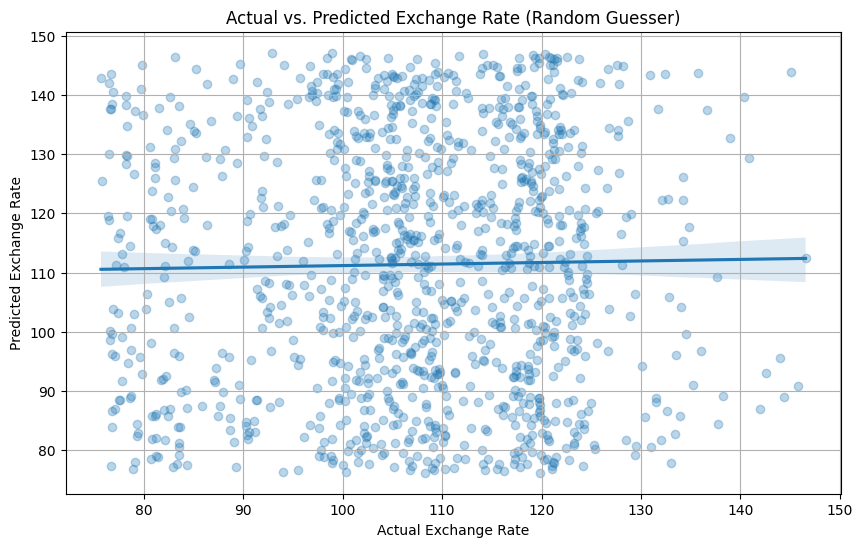

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Check that 'Date' columns are datetime
df['Date'] = pd.to_datetime(df['Date'])
macro_df['DATE'] = pd.to_datetime(macro_df['DATE'])

# Merge df and macro_df on Date and Use 'DEXJPUS' from df as the target variable
merged_df = pd.merge(df[['Date', 'DEXJPUS']], macro_df, left_on='Date', right_on='DATE', how='inner')
merged_df = merged_df.drop(columns=['DATE'])

# Drop NaNs values
merged_df = merged_df.dropna()

# Define features (X) and target (y)
features = ['US_GDP', 'Japan_GDP', 'US_Unemployment', 'Japan_Unemployment',
            'US_M2', 'Japan_M2']

X = merged_df[features]
y = merged_df['DEXJPUS']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print()

class RandomGuesser:
    def __init__(self, random_state=None):
        self.random_state = random_state
        self.min_val = None
        self.max_val = None

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.min_val = y.min()
        self.max_val = y.max()
        print(f"RandomGuesser fitted. Target range: [{self.min_val:.2f}, {self.max_val:.2f}]")

    def predict(self, X):
        if self.min_val is None or self.max_val is None:
            raise RuntimeError("RandomGuesser must be fitted before predicting.")
        return np.random.uniform(self.min_val, self.max_val, size=len(X))

model = RandomGuesser(random_state=42)
model.fit(X_train, y_train)

print("Model prediction complete.")

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print()
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.3})
plt.xlabel("Actual Exchange Rate")
plt.ylabel("Predicted Exchange Rate")
plt.title("Actual vs. Predicted Exchange Rate (Random Guesser)")
plt.grid(True)
plt.show()

### Old Iterations of models - with (1) price based features and (2) monthly features
This cell has examples of LSTM approaches that we tried before creating our final model. The first model below shows the results using price based features and the second one uses macro data but with a monthly frequency.

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


def create_technical_features(df, price_col="rate"):
    df = df.copy()

    for period in [1, 5, 10, 20]:
        df[f"return_{period}d"] = df[price_col].pct_change(period)

    for window in [5, 10, 20, 50]:
        df[f"SMA_{window}"] = df[price_col].rolling(window).mean()
        df[f"price_vs_SMA{window}"] = df[price_col] / df[f"SMA_{window}"] - 1

    df["SMA5_vs_SMA20"] = df["SMA_5"] / df["SMA_20"] - 1
    df["SMA10_vs_SMA50"] = df["SMA_10"] / df["SMA_50"] - 1

    df["volatility_5"] = df["return_1d"].rolling(5).std()
    df["volatility_20"] = df["return_1d"].rolling(20).std()
    df["vol_ratio"] = df["volatility_5"] / df["volatility_20"]

    delta = df[price_col].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / (loss + 1e-10)
    df["RSI"] = 100 - (100 / (1 + rs))

    bb_mid = df[price_col].rolling(20).mean()
    bb_std = df[price_col].rolling(20).std()
    df["BB_position"] = (df[price_col] - bb_mid) / (2 * bb_std + 1e-10)

    ema12 = df[price_col].ewm(span=12).mean()
    ema26 = df[price_col].ewm(span=26).mean()
    df["MACD"] = ema12 - ema26
    df["MACD_signal"] = df["MACD"].ewm(span=9).mean()
    df["MACD_hist"] = df["MACD"] - df["MACD_signal"]

    df["momentum_10"] = df[price_col].pct_change(10)
    df["momentum_20"] = df[price_col].pct_change(20)

    return df


def prepare_sequences(features, targets, lookback):
    X, y = [], []
    for i in range(lookback, len(features)):
        X.append(features[i - lookback:i])
        y.append(targets[i])
    return np.array(X), np.array(y)


def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(32, input_shape=input_shape, return_sequences=True,
             kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        LSTM(16, return_sequences=False, kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        BatchNormalization(),
        Dense(8, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


def evaluate_model(y_true, y_pred, y_prob):
    print(f"\nAccuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification report:")
    print(classification_report(y_true, y_pred))
    print(f"Mean prob: {y_prob.mean():.4f}, Std: {y_prob.std():.4f}")


def approach_price_based():
    np.random.seed(42)
    n_days = 5000
    dates = pd.date_range("2005-01-01", periods=n_days, freq="B")

    returns = np.random.randn(n_days) * 0.005
    prices = 110 * np.exp(np.cumsum(returns))

    df = pd.DataFrame({"rate": prices}, index=dates)
    df = create_technical_features(df, "rate")

    df["target"] = (df["rate"].shift(-1) > df["rate"]).astype(int)

    feature_cols = [
        "return_5d", "return_10d", "return_20d",
        "price_vs_SMA5", "price_vs_SMA10", "price_vs_SMA20",
        "SMA5_vs_SMA20", "SMA10_vs_SMA50",
        "volatility_5", "volatility_20", "vol_ratio",
        "RSI", "BB_position",
        "MACD", "MACD_signal", "MACD_hist",
        "momentum_10", "momentum_20"
    ]

    df = df.dropna()

    features = df[feature_cols].values
    targets = df["target"].values

    train_size = int(len(df) * 0.8)

    scaler = StandardScaler()
    feat_train = scaler.fit_transform(features[:train_size])
    feat_test = scaler.transform(features[train_size:])

    tgt_train = targets[:train_size]
    tgt_test = targets[train_size:]

    lookback = 20
    X_train, y_train = prepare_sequences(feat_train, tgt_train, lookback)
    X_test, y_test = prepare_sequences(feat_test, tgt_test, lookback)

    model = build_lstm_model((lookback, len(feature_cols)))

    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.15,
        callbacks=[
            EarlyStopping(patience=10, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=5)
        ],
        verbose=0
    )

    y_prob = model.predict(X_test, verbose=0).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    evaluate_model(y_test, y_pred, y_prob)
    return model


def approach_monthly_frequency():
    np.random.seed(42)
    n_months = 360
    dates = pd.date_range("1995-01-01", periods=n_months, freq="M")

    fx_returns = np.random.randn(n_months) * 0.02
    fx_rate = 110 * np.exp(np.cumsum(fx_returns))

    us_gdp = 10000 * np.exp(np.cumsum(np.random.randn(n_months) * 0.003 + 0.002))
    jp_gdp = 500000 * np.exp(np.cumsum(np.random.randn(n_months) * 0.002 + 0.001))
    us_unemp = 5 + np.cumsum(np.random.randn(n_months) * 0.1)
    us_unemp = np.clip(us_unemp, 3, 12)
    jp_unemp = 3 + np.cumsum(np.random.randn(n_months) * 0.05)
    jp_unemp = np.clip(jp_unemp, 2, 6)

    us_rate = 3 + np.cumsum(np.random.randn(n_months) * 0.1)
    us_rate = np.clip(us_rate, 0.1, 8)
    jp_rate = 1 + np.cumsum(np.random.randn(n_months) * 0.05)
    jp_rate = np.clip(jp_rate, -0.5, 3)
    rate_diff = us_rate - jp_rate

    df = pd.DataFrame({
        "fx_rate": fx_rate,
        "us_gdp": us_gdp,
        "jp_gdp": jp_gdp,
        "us_unemp": us_unemp,
        "jp_unemp": jp_unemp,
        "rate_diff": rate_diff,
        "us_rate": us_rate,
        "jp_rate": jp_rate
    }, index=dates)

    df["gdp_ratio"] = np.log(df["us_gdp"]) - np.log(df["jp_gdp"])
    df["unemp_diff"] = df["us_unemp"] - df["jp_unemp"]
    df["gdp_ratio_chg"] = df["gdp_ratio"].diff(3)
    df["rate_diff_chg"] = df["rate_diff"].diff()

    for col in ["gdp_ratio", "unemp_diff", "rate_diff"]:
        df[f"{col}_lag1"] = df[col].shift(1)
        df[f"{col}_lag3"] = df[col].shift(3)

    df["fx_return_1m"] = df["fx_rate"].pct_change(1)
    df["fx_return_3m"] = df["fx_rate"].pct_change(3)
    df["fx_return_6m"] = df["fx_rate"].pct_change(6)

    df["target"] = (df["fx_rate"].shift(-1) > df["fx_rate"]).astype(int)

    feature_cols = [
        "gdp_ratio_lag1", "gdp_ratio_lag3",
        "unemp_diff_lag1", "unemp_diff_lag3",
        "rate_diff_lag1", "rate_diff_lag3",
        "rate_diff_chg",
        "fx_return_1m", "fx_return_3m", "fx_return_6m"
    ]

    df = df.dropna()

    features = df[feature_cols].values
    targets = df["target"].values

    train_size = int(len(df) * 0.8)

    scaler = StandardScaler()
    feat_train = scaler.fit_transform(features[:train_size])
    feat_test = scaler.transform(features[train_size:])

    lookback = 12
    X_train, y_train = prepare_sequences(feat_train, targets[:train_size], lookback)
    X_test, y_test = prepare_sequences(feat_test, targets[train_size:], lookback)

    model = Sequential([
        LSTM(16, input_shape=(lookback, len(feature_cols))),
        Dropout(0.3),
        Dense(8, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=16,
        validation_split=0.2,
        callbacks=[EarlyStopping(patience=15, restore_best_weights=True)],
        verbose=0
    )

    y_prob = model.predict(X_test, verbose=0).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    evaluate_model(y_test, y_pred, y_prob)
    return model


if __name__ == "__main__":
    print("Running daily price-based model...")
    approach_price_based()

    print("\nRunning monthly macro model...")
    approach_monthly_frequency()

Running daily price-based model...

Accuracy: 0.4840

Confusion matrix:
[[224 265]
 [236 246]]

Classification report:
              precision    recall  f1-score   support

           0       0.49      0.46      0.47       489
           1       0.48      0.51      0.50       482

    accuracy                           0.48       971
   macro avg       0.48      0.48      0.48       971
weighted avg       0.48      0.48      0.48       971

Mean prob: 0.5045, Std: 0.0288

Running monthly macro model...

Accuracy: 0.6102

Confusion matrix:
[[23  7]
 [16 13]]

Classification report:
              precision    recall  f1-score   support

           0       0.59      0.77      0.67        30
           1       0.65      0.45      0.53        29

    accuracy                           0.61        59
   macro avg       0.62      0.61      0.60        59
weighted avg       0.62      0.61      0.60        59

Mean prob: 0.4755, Std: 0.0432


### Advanced Feature Engineering and Multi-Approach LSTM Testing (Synthetic Data)
This comprehensive cell defines functions for advanced technical feature engineering, building regularized LSTM models, and evaluating them. It then explores three distinct approaches for exchange rate prediction using synthetic data:
1.  Price-Based Technical Features: Using only technical indicators from price data.
2.  Monthly Frequency with Macro Data: Incorporating macroeconomic features at a monthly frequency.
3.  Multi-Day Target with Threshold: Predicting significant multi-day directional moves.
Each approach is evaluated, and a summary of recommendations based on the findings from synthetic data is provided.

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


def create_technical_features(df, price_col="rate"):
    df = df.copy()

    for period in [1, 5, 10, 20]:
        df[f"return_{period}d"] = df[price_col].pct_change(period)

    for window in [5, 10, 20, 50]:
        df[f"SMA_{window}"] = df[price_col].rolling(window).mean()
        df[f"price_vs_SMA{window}"] = df[price_col] / df[f"SMA_{window}"] - 1

    df["SMA5_vs_SMA20"] = df["SMA_5"] / df["SMA_20"] - 1
    df["SMA10_vs_SMA50"] = df["SMA_10"] / df["SMA_50"] - 1

    df["volatility_5"] = df["return_1d"].rolling(5).std()
    df["volatility_20"] = df["return_1d"].rolling(20).std()
    df["vol_ratio"] = df["volatility_5"] / df["volatility_20"]

    delta = df[price_col].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / (loss + 1e-10)
    df["RSI"] = 100 - (100 / (1 + rs))

    bb_mid = df[price_col].rolling(20).mean()
    bb_std = df[price_col].rolling(20).std()
    df["BB_position"] = (df[price_col] - bb_mid) / (2 * bb_std + 1e-10)

    ema12 = df[price_col].ewm(span=12).mean()
    ema26 = df[price_col].ewm(span=26).mean()
    df["MACD"] = ema12 - ema26
    df["MACD_signal"] = df["MACD"].ewm(span=9).mean()
    df["MACD_hist"] = df["MACD"] - df["MACD_signal"]

    df["momentum_10"] = df[price_col].pct_change(10)
    df["momentum_20"] = df[price_col].pct_change(20)

    return df


def prepare_sequences(features, targets, lookback):
    X, y = [], []
    for i in range(lookback, len(features)):
        X.append(features[i - lookback:i])
        y.append(targets[i])
    return np.array(X), np.array(y)


def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(32, input_shape=input_shape, return_sequences=True,
             kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        LSTM(16, return_sequences=False, kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        BatchNormalization(),
        Dense(8, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


def evaluate_model(y_true, y_pred, y_prob):
    print(f"\nAccuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification report:")
    print(classification_report(y_true, y_pred))
    print(f"Mean prob: {y_prob.mean():.4f}, Std: {y_prob.std():.4f}")


def approach_multiday_target():
    np.random.seed(42)
    n_days = 5000
    dates = pd.date_range("2005-01-01", periods=n_days, freq="B")

    returns = np.random.randn(n_days) * 0.005
    prices = 110 * np.exp(np.cumsum(returns))

    df = pd.DataFrame({"rate": prices}, index=dates)
    df = create_technical_features(df, "rate")

    df["future_return_5d"] = df["rate"].shift(-5) / df["rate"] - 1

    threshold = 0.005
    df["target"] = np.where(
        df["future_return_5d"] > threshold, 1,
        np.where(df["future_return_5d"] < -threshold, 0, np.nan)
    )

    feature_cols = [
        "return_5d", "return_10d", "return_20d",
        "price_vs_SMA5", "price_vs_SMA20",
        "SMA5_vs_SMA20",
        "volatility_5", "volatility_20",
        "RSI", "BB_position",
        "MACD_hist", "momentum_10"
    ]

    df = df.dropna()

    features = df[feature_cols].values
    targets = df["target"].astype(int).values

    train_size = int(len(df) * 0.8)

    scaler = StandardScaler()
    feat_train = scaler.fit_transform(features[:train_size])
    feat_test = scaler.transform(features[train_size:])

    lookback = 10
    X_train, y_train = prepare_sequences(feat_train, targets[:train_size], lookback)
    X_test, y_test = prepare_sequences(feat_test, targets[train_size:], lookback)

    model = build_lstm_model((lookback, len(feature_cols)))

    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.15,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=0
    )

    y_prob = model.predict(X_test, verbose=0).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    evaluate_model(y_test, y_pred, y_prob)
    return model


if __name__ == "__main__":
    approach_multiday_target()


Accuracy: 0.4640

Confusion matrix:
[[ 40 298]
 [ 37 250]]

Classification report:
              precision    recall  f1-score   support

           0       0.52      0.12      0.19       338
           1       0.46      0.87      0.60       287

    accuracy                           0.46       625
   macro avg       0.49      0.49      0.40       625
weighted avg       0.49      0.46      0.38       625

Mean prob: 0.5416, Std: 0.0393


### Real Data Testing and Evaluation
This section applies the refined methodology to the *actual* Yen/USD and macroeconomic datasets. It includes functions to load real data, create lagged technical and macroeconomic features, and define a multi-day directional target with a significance threshold. It uses robust time-series data splitting with a gap to prevent leakage. A baseline test on random data is performed first to confirm model integrity. Finally, the LSTM model is built, trained, and thoroughly with metrics, learning curves, prediction distributions, and monthly accuracy analysis.

Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5152 - loss: 1.2975 - val_accuracy: 0.5271 - val_loss: 1.1147
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5444 - loss: 1.1243 - val_accuracy: 0.5341 - val_loss: 1.0219
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5556 - loss: 1.0067 - val_accuracy: 0.5129 - val_loss: 0.9549
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5593 - loss: 0.9349 - val_accuracy: 0.5224 - val_loss: 0.9083
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5321 - loss: 0.9017 - val_accuracy: 0.4988 - val_loss: 0.8795
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5629 - loss: 0.8550 - val_accuracy: 0.5035 - val_loss: 0.8495
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5551 - loss: 0.8220 - val_accuracy: 0.5035 - val_loss: 0.8289
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5656 - loss: 0.7972 - val_accuracy: 0.4847 - val_l

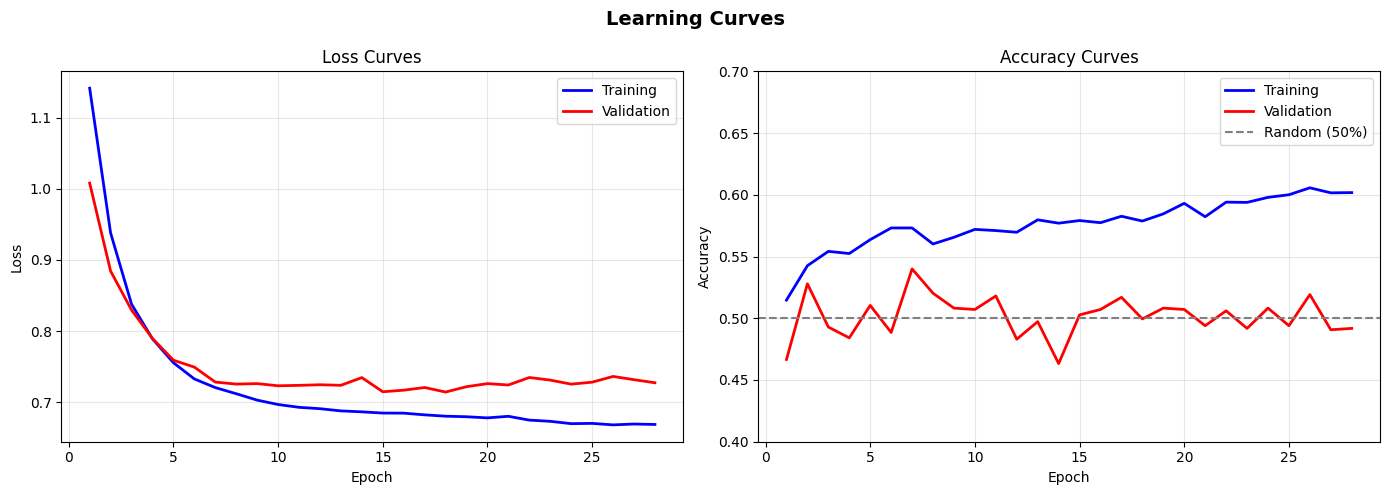

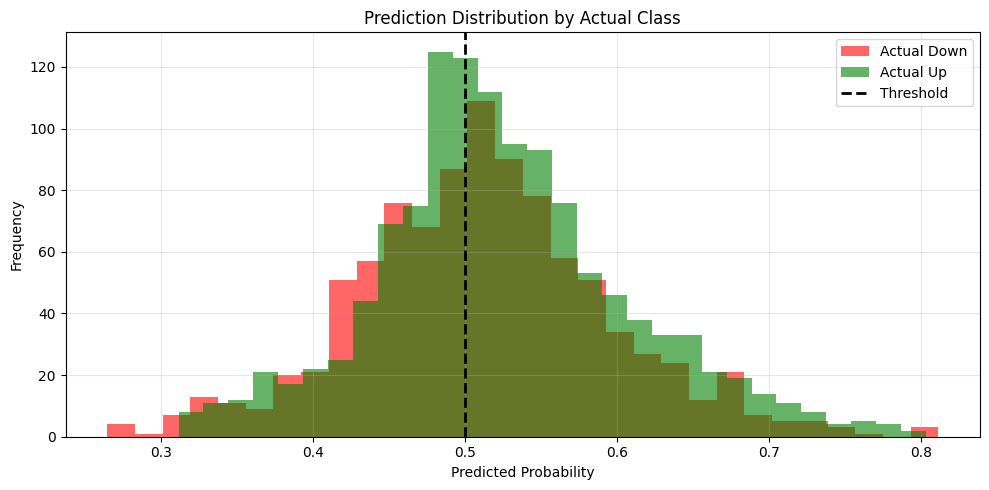


Accuracy by Month:
year_month
2012-04    0.000000
2012-05    0.428571
2012-06    0.416667
2012-07    0.363636
2012-08    0.333333
             ...   
2025-06    0.615385
2025-07    0.650000
2025-08    0.333333
2025-09    0.533333
2025-10    0.705882
Freq: M, Length: 163, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


def load_real_fx_data(filepath='YenUSD.csv'):
    df = pd.read_csv(filepath)
    df = df.rename(columns={'observation_date': 'Date', 'DEXJPUS': 'rate'})
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date').sort_index()
    df['rate'] = pd.to_numeric(df['rate'], errors='coerce')
    df = df.dropna()
    return df


def load_real_macro_data():
    us_gdp = pd.read_csv('US_GDP.csv')
    jp_gdp = pd.read_csv('Japan_GDP.csv')
    us_unemp = pd.read_csv('US_Unemployment.csv')
    jp_unemp = pd.read_csv('Japan_Unemployment.csv')
    us_m2 = pd.read_csv('M2_US.csv')
    jp_m2 = pd.read_csv('M2_Japan.csv')
    us_10yr = pd.read_csv('US_10yield.csv')
    jp_10yr = pd.read_csv('JPN_10yield.csv')

    def process_macro(df, value_name):
        df = df.rename(columns={'observation_date': 'Date'})
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        val_col = [c for c in df.columns if c != 'Date'][0]
        df = df[[val_col]].rename(columns={val_col: value_name})
        return df

    us_gdp = process_macro(us_gdp, 'US_GDP')
    jp_gdp = process_macro(jp_gdp, 'Japan_GDP')
    us_unemp = process_macro(us_unemp, 'US_Unemployment')
    jp_unemp = process_macro(jp_unemp, 'Japan_Unemployment')
    us_m2 = process_macro(us_m2, 'US_M2')
    jp_m2 = process_macro(jp_m2, 'Japan_M2')
    us_10yr = process_macro(us_10yr, 'US_10yield')
    jp_10yr = process_macro(jp_10yr, 'JPN_10yield')

    macro = us_gdp.join(jp_gdp, how='outer')
    macro = macro.join(us_unemp, how='outer')
    macro = macro.join(jp_unemp, how='outer')
    macro = macro.join(us_m2, how='outer')
    macro = macro.join(jp_m2, how='outer')
    macro = macro.join(us_10yr, how='outer')
    macro = macro.join(jp_10yr, how='outer')

    return macro


def create_technical_features(df, price_col='rate'):
    df = df.copy()

    for period in [1, 5, 10, 20]:
        df[f'return_{period}d_lag1'] = df[price_col].pct_change(period).shift(1)

    for window in [5, 10, 20, 50]:
        sma = df[price_col].rolling(window).mean()
        df[f'price_vs_SMA{window}_lag1'] = (df[price_col].shift(1) / sma.shift(1) - 1)

    sma5 = df[price_col].rolling(5).mean()
    sma20 = df[price_col].rolling(20).mean()
    sma50 = df[price_col].rolling(50).mean()
    df['SMA5_vs_SMA20_lag1'] = (sma5 / sma20 - 1).shift(1)
    df['SMA20_vs_SMA50_lag1'] = (sma20 / sma50 - 1).shift(1)

    daily_ret = df[price_col].pct_change()
    df['volatility_5_lag1'] = daily_ret.rolling(5).std().shift(1)
    df['volatility_20_lag1'] = daily_ret.rolling(20).std().shift(1)
    df['vol_ratio_lag1'] = (df['volatility_5_lag1'] / df['volatility_20_lag1'])

    delta = df[price_col].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / (loss + 1e-10)
    df['RSI_lag1'] = (100 - (100 / (1 + rs))).shift(1)

    bb_mid = df[price_col].rolling(20).mean()
    bb_std = df[price_col].rolling(20).std()
    df['BB_position_lag1'] = ((df[price_col] - bb_mid) / (2 * bb_std + 1e-10)).shift(1)

    ema12 = df[price_col].ewm(span=12).mean()
    ema26 = df[price_col].ewm(span=26).mean()
    macd = ema12 - ema26
    macd_signal = macd.ewm(span=9).mean()
    df['MACD_hist_lag1'] = (macd - macd_signal).shift(1)

    df['momentum_10_lag1'] = df[price_col].pct_change(10).shift(1)
    df['momentum_20_lag1'] = df[price_col].pct_change(20).shift(1)

    return df


def add_macro_features(fx_df, macro_df):
    macro_daily = macro_df.resample('D').ffill()
    macro_daily = macro_daily.shift(30)

    macro_daily['rate_diff'] = macro_daily.get('US_Rate', 0) - macro_daily.get('Japan_Rate', 0)

    if 'US_GDP' in macro_daily.columns and 'Japan_GDP' in macro_daily.columns:
        macro_daily['gdp_ratio'] = np.log(macro_daily['US_GDP'] + 1) - np.log(macro_daily['Japan_GDP'] + 1)

    if 'US_Unemployment' in macro_daily.columns and 'Japan_Unemployment' in macro_daily.columns:
        macro_daily['unemp_diff'] = macro_daily['US_Unemployment'] - macro_daily['Japan_Unemployment']

    merged = fx_df.join(macro_daily, how='left')
    merged = merged.ffill()
    return merged


def create_target(df, price_col='rate', horizon=5, threshold=0.005):
    df = df.copy()
    df['future_return'] = df[price_col].shift(-horizon) / df[price_col] - 1
    df['target'] = np.where(
        df['future_return'] > threshold, 1,
        np.where(df['future_return'] < -threshold, 0, np.nan)
    )
    return df


def create_sequences_with_gap(features, targets, lookback, gap=5):
    X, y = [], []
    for i in range(lookback + gap, len(features)):
        X.append(features[i-lookback-gap:i-gap])
        y.append(targets[i])
    return np.array(X), np.array(y)


def temporal_train_test_split(X, y, train_ratio=0.7, gap_ratio=0.05):
    n = len(X)
    train_end = int(n * train_ratio)
    gap_end = int(n * (train_ratio + gap_ratio))

    X_train = X[:train_end]
    y_train = y[:train_end]
    X_test = X[gap_end:]
    y_test = y[gap_end:]

    return X_train, X_test, y_train, y_test


def build_model(input_shape):
    model = Sequential([
        LSTM(32, input_shape=input_shape, return_sequences=False,
             kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        BatchNormalization(),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


def evaluate_model(y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    print(f"\nAccuracy: {acc:.4f} (baseline: 0.5000, improvement: {(acc - 0.5)*100:+.2f}%)")

    if acc > 0.65:
        print("WARNING: Accuracy > 65% is suspicious - likely data leakage")

    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix:\n{cm}")

    if cm.shape != (2, 2):
        print("Model is only predicting one class")

    print(classification_report(y_true, y_pred, target_names=['Down', 'Up'], zero_division=0))

    print(f"Prediction stats - Mean: {y_prob.mean():.4f}, Std: {y_prob.std():.4f}")
    print(f"Predictions - Down: {(y_pred == 0).sum()}, Up: {(y_pred == 1).sum()}")


def plot_learning_curves(history, title="Learning Curves"):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    epochs = range(1, len(history.history['loss']) + 1)

    axes[0].plot(epochs, history.history['loss'], 'b-', label='Training', linewidth=2)
    axes[0].plot(epochs, history.history['val_loss'], 'r-', label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss Curves')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(epochs, history.history['accuracy'], 'b-', label='Training', linewidth=2)
    axes[1].plot(epochs, history.history['val_accuracy'], 'r-', label='Validation', linewidth=2)
    axes[1].axhline(y=0.5, color='gray', linestyle='--', label='Random (50%)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy Curves')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0.4, 0.7])

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def plot_predictions(y_prob, y_test):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(y_prob[y_test == 0], bins=30, alpha=0.6, label='Actual Down', color='red')
    ax.hist(y_prob[y_test == 1], bins=30, alpha=0.6, label='Actual Up', color='green')
    ax.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Frequency')
    ax.set_title('Prediction Distribution by Actual Class')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def run_with_real_data():
    fx_df = load_real_fx_data('YenUSD.csv')

    try:
        macro_df = load_real_macro_data()
        use_macro = True
    except:
        use_macro = False

    df = create_technical_features(fx_df, 'rate')

    if use_macro:
        df = add_macro_features(df, macro_df)

    df = create_target(df, 'rate', horizon=5, threshold=0.005)

    feature_cols = [c for c in df.columns if c.endswith('_lag1') or c in [
        'rate_diff', 'gdp_ratio', 'unemp_diff'
    ]]
    feature_cols = [c for c in feature_cols if c in df.columns]

    df_clean = df.dropna(subset=feature_cols + ['target'])

    features = df_clean[feature_cols].values
    targets = df_clean['target'].astype(int).values

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    lookback = 10
    gap = 5

    X, y = create_sequences_with_gap(features_scaled, targets, lookback, gap)
    X_train, X_test, y_train, y_test = temporal_train_test_split(X, y, train_ratio=0.7, gap_ratio=0.05)

    model = build_model((lookback, len(feature_cols)))

    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.15,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True, verbose=1)],
        verbose=1
    )

    y_prob = model.predict(X_test, verbose=0).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    evaluate_model(y_test, y_pred, y_prob)
    plot_learning_curves(history)
    plot_predictions(y_prob, y_test)

    return model, history, df_clean, y_test, y_pred


def run_baseline_test():
    np.random.seed(42)
    n_days = 5000
    returns = np.random.randn(n_days) * 0.01
    prices = 100 * np.exp(np.cumsum(returns))

    dates = pd.date_range('2000-01-01', periods=n_days, freq='B')
    df = pd.DataFrame({'rate': prices}, index=dates)

    df = create_technical_features(df, 'rate')
    df = create_target(df, 'rate', horizon=5, threshold=0.005)

    feature_cols = [c for c in df.columns if c.endswith('_lag1')]
    df_clean = df.dropna(subset=feature_cols + ['target'])

    features = df_clean[feature_cols].values
    targets = df_clean['target'].astype(int).values

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    lookback = 10
    gap = 5

    X, y = create_sequences_with_gap(features_scaled, targets, lookback, gap)
    X_train, X_test, y_train, y_test = temporal_train_test_split(X, y)

    model = build_model((lookback, len(feature_cols)))

    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_split=0.15,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=1
    )

    y_prob = model.predict(X_test, verbose=0).flatten()
    y_pred = (y_prob > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)

    print(f"\nBaseline accuracy: {acc:.4f} (expected ~0.50)")
    if acc > 0.55:
        print("Accuracy > 55% on random walk suggests data leakage")
    elif acc < 0.45:
        print("Accuracy < 45% suggests model issues")
    else:
        print("Baseline passed - no obvious leakage")

    return acc


if __name__ == "__main__":
    baseline_acc = run_baseline_test()

    if baseline_acc > 0.55:
        print("Baseline failed - fix leakage before using real data")
    else:
        print("Running with real data...")
        model, history, df_clean, y_test, y_pred = run_with_real_data()

        test_start_idx = len(df_clean) - len(y_test)
        test_dates = df_clean.index[test_start_idx:]

        eval_df = pd.DataFrame({
            'date': test_dates,
            'y_true': y_test,
            'y_pred': y_pred
        })

        eval_df['year_month'] = eval_df['date'].dt.to_period('M')
        monthly_accuracy = eval_df.groupby('year_month').apply(
            lambda x: (x['y_true'] == x['y_pred']).mean()
        )

        print("\nAccuracy by Month:")
        print(monthly_accuracy)